# Machine Learning, Python y el Titanic

#### Guillermo Moncecchi (@gmonce) - Basado en el capítulo 2 del libro "Learning scikit-learn: Machine Learning in Python"

_¿Es posible tejer hipótesis sobre quiénes se salvaron en el Titanic? En este pequeño ejercicio, intentaremos generarlas a partir de la información que tenemos de los pasajeros, sabiendo si se salvaron o no. Para esto, el modelo predictivo a utilizar serán [Árboles de Decisión](http://en.wikipedia.org/wiki/Decision_tree_learning). El conjunto de datos (dataset) a utilizar puede bajarse [aquí](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt)_

Importamos las bibliotecas que vamos a utilizar. Las principales son numpy (la biblioteca principal para computación científica con Python), y, por supuesto scikit-learn (que nos permitirá entrenar y aplicar el modelo elegido).  

In [2]:
import IPython
import sklearn as sk
import numpy as np
import pydot
import pyparsing

print 'IPython version:', IPython.__version__
print 'numpy version:', np.__version__
print 'scikit-learn version:', sk.__version__
print 'pydot version:', pydot.__version__
print 'pyparsing version:', pyparsing.__version__

 IPython version: 2.2.0
numpy version: 1.9.0
scikit-learn version: 0.15.2
pydot version: 1.0.28
pyparsing version: 1.5.6


_Notar que la versión de pyparsing es la 1.5.6, pydot tiene problemas con pyparsing >=2.0, por lo tanto tenemos que recurir a una versión anterior. Más info: http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will/21462609#21462609_. Si tienen instalado Anaconda (muy recomendado!), basta con hacer:

    $ conda remove pyparsing
$ conda install conda install pyparsing==1.5.6



### Preprocesamiento e Ingeniería de Atributos

Vamos a leer el archivo que tenemos...

La lista de atributos es: Ordinal, Class, Survived (0=no, 1=yes), Name, Age, Port of Embarkation, Home/Destination, Room, Ticket, Boat, and Sex. Empecemos por cargar nuestro archivo a un array de numpy, para poder trabajar más cómodos (hay herramientas mucho mejores para manejar estos atributos, como [pandas](http://pandas.pydata.org/), pero mantengamos las cosas simples, ya que nuestro problema no es complicado):

In [3]:
import csv
with open('../data/titanic.txt', 'rb') as csvfile:
    titanic_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    # Importo el dataset como array de numpy
    titanic_dataset = np.array([ row for row in titanic_reader])
    print titanic_dataset[12]
    
    # La primera fila tiene los nombres de los atributos
    feature_names = titanic_dataset[0]
    print feature_names
    
    # En la columna 2 tenemos la clase que queremos predecir (es decir, si sobrevivió o no)
    # Vale 1 si sobrevivió, 0 si no.
    titanic_y=titanic_dataset[1:,2].astype(float)
    print titanic_y[12]


['12' '1st' '1' 'Astor, Mrs John Jacob (Madeleine Talmadge Force)'
 '19.0000' 'Cherbourg' 'New York, NY' '' '17754 L224 10s 6d' '4' 'female']
['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']
1.0


Veamos cómo quedan las tuplas...

In [4]:
print zip(feature_names, titanic_dataset[1])

[('row.names', '1'), ('pclass', '1st'), ('survived', '1'), ('name', 'Allen, Miss Elisabeth Walton'), ('age', '29.0000'), ('embarked', 'Southampton'), ('home.dest', 'St Louis, MO'), ('room', 'B-5'), ('ticket', '24160 L221'), ('boat', '2'), ('sex', 'female')]


La primera tupla corresponde a Elisabeth Walton, de 29 años, que embarcó en Southampton, iba a St. Louis,estaba en el cuarto B-5, y tenía el ticket 24160 L221, en primera clase. Elisabeth sobrevivió.Estos datos los tenemos para todos los pasajeros. Aquí es donde tenemos que elegir las features que vamos a usar para aprender. En este caso, elegimos la clase, la edad, y el sexo. El destino no parece influenciar mucho, dónde embarcó tampoco... de acuerdo a nuestro conocimiento... aunque nada nos impide agregarlo luego como feature. El nombre no puede ir, ya que es imposible que sirva para generalizar. Por supuesto, no podemos usar para predecir la clase que estamos tratando de adivinar, así que la columna "survived" también desaparece.

In [5]:
# Elegimos las columnas que tiene la clase, la edad, y el sexo
titanic_X = titanic_dataset[1:, [1, 4, 10]]
#print [row in titanic_X if row[1]=='NA']
#print zip(titanic_X[0:100].tolist(), titanic_y[1:100].tolist())
print zip(titanic_X[10:20].tolist(), titanic_y[10:20].tolist())



[(['1st', '47.0000', 'male'], 0.0), (['1st', '19.0000', 'female'], 1.0), (['1st', 'NA', 'female'], 1.0), (['1st', 'NA', 'male'], 1.0), (['1st', 'NA', 'male'], 0.0), (['1st', '50.0000', 'female'], 1.0), (['1st', '24.0000', 'male'], 0.0), (['1st', '36.0000', 'male'], 0.0), (['1st', '37.0000', 'male'], 1.0), (['1st', '47.0000', 'female'], 1.0)]


Tenemos algunos problemas con la edad: en algunos casos no tiene valores:

In [6]:
print titanic_X[14]


['1st' 'NA' 'male']


Tenemos que hacer algo: elegimos poner el valor medio...

In [7]:
# Calculo la edad promedio
edades = titanic_X[:, 1]
edad_promedio=np.mean(titanic_X[edades != 'NA', 1].astype(np.float))
print edad_promedio

# Actualizo
titanic_X[titanic_X[:, 1] == 'NA', 1] = edad_promedio
print zip(titanic_X[10:20].tolist(), titanic_y[10:20].tolist())


31.1941810427
[(['1st', '47.0000', 'male'], 0.0), (['1st', '19.0000', 'female'], 1.0), (['1st', '31.1941810427', 'female'], 1.0), (['1st', '31.1941810427', 'male'], 1.0), (['1st', '31.1941810427', 'male'], 0.0), (['1st', '50.0000', 'female'], 1.0), (['1st', '24.0000', 'male'], 0.0), (['1st', '36.0000', 'male'], 0.0), (['1st', '37.0000', 'male'], 1.0), (['1st', '47.0000', 'female'], 1.0)]


Bien. Veamos ahora la clase y el sexo: el clasificador que vamos a usar espera atributos que son números reales y hoy los tenemos como categorías. Empecemos por sexo: solamente hay dos categorías, por lo que podemos decir (por ejemplo) que femenino es 0 y masculino es 1. scikit-learn nos provee de una clase LabelEncoder que hace esto...:

In [8]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
# Le paso los valores que tengo y el asigna un entero a cada clase posible
label_encoder = enc.fit(titanic_X[:, 2])
print "Categorical classes:", label_encoder.classes_
# Veamos como las transforma...
integer_classes = label_encoder.transform(label_encoder.classes_)
print "Integer classes:", zip(label_encoder.classes_,integer_classes)

t = label_encoder.transform(titanic_X[:, 2])
titanic_X[:, 2] = t
print zip(titanic_X[10:20].tolist(), titanic_y[10:20].tolist())


Categorical classes: ['female' 'male']
Integer classes: [('female', 0), ('male', 1)]
[(['1st', '47.0000', '1'], 0.0), (['1st', '19.0000', '0'], 1.0), (['1st', '31.1941810427', '0'], 1.0), (['1st', '31.1941810427', '1'], 1.0), (['1st', '31.1941810427', '1'], 0.0), (['1st', '50.0000', '0'], 1.0), (['1st', '24.0000', '1'], 0.0), (['1st', '36.0000', '1'], 0.0), (['1st', '37.0000', '1'], 1.0), (['1st', '47.0000', '0'], 1.0)]


Bien, nos resta la clase del pasajero. Tenemos primera, segunda y tercera. Para evitar un ordenamiento implícito (0<1<2), vamos a usar otra técnica, llamada "One Hot Encoding". Lo mejor es verlo con un ejemplo, pero la idea es convertir cada atributo en n, siendo n los valores posibles de ese atributo. Para este caso, generaremos los atributos: primera_clase, segunda_clase, y tercera_clase, valuados en 0/1.

In [9]:
from sklearn.preprocessing import OneHotEncoder
lencoder = LabelEncoder()
label_encoder = lencoder.fit(titanic_X[:,0])
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3,1)
#titanic_integer_classes=label_encoder.transform(titanic_X[:,0])
enc = OneHotEncoder()
one_hot_encoder=enc.fit(integer_classes)
# First, convert clases to 0-(N-1) integers using label_encoder
num_of_rows = titanic_X.shape[0]
t = label_encoder.transform(titanic_X[:, 0]).reshape(num_of_rows, 1)
# Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
new_features = one_hot_encoder.transform(t)
# Add the new features to titanix_X
titanic_X = np.concatenate([titanic_X, new_features.toarray()], axis = 1)
#Eliminate converted columns
titanic_X = np.delete(titanic_X, [0], 1)
# Update feature names
feature_names = ['edad', 'sexo', 'primera_clase', 'segunda_clase', 'tercera_clase']
# Convert to numerical values
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)


In [10]:
print 'New feature names:',feature_names
print 'Values:',titanic_X[0]
print 'Objetivo:', titanic_y[0]

New feature names: ['edad', 'sexo', 'primera_clase', 'segunda_clase', 'tercera_clase']
Values: [ 29.   0.   1.   0.   0.]
Objetivo: 1.0


In [19]:
print titanic_X

[[ 29.           0.           1.           0.           0.        ]
 [  2.           0.           1.           0.           0.        ]
 [ 30.           1.           1.           0.           0.        ]
 ..., 
 [ 31.19418104   1.           0.           0.           1.        ]
 [ 31.19418104   0.           0.           0.           1.        ]
 [ 31.19418104   1.           0.           0.           1.        ]]


Ya tenemos pronto el dataset, recién ahora comienza el proceso de aprendizaje. Vamos primero separar el dataset en dos: un conjunto de entrenamiento y otro de testeo. Trabajaremos siempre sobre el de entrenamiento, y dejamos el de testeo para evaluar nuestros resultados. Lo dividimos en 75/25:

In [11]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)


### Árboles de Decision

Vamos a crear a partir de los datos de entrenamiento, un árbol de decision. Esto en scikit-learn es estándar... y fácil, una vez que tenemos los datos en el formato pedido: basta crear el clasificador y usarlo para generar el modelo: 

In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

The decision tree we have built represents a series of decisions based on the training data. To classify an instance, we should answer the question at each node. For example, at our root node, the question is: Is sex<=0.5? (are we talking about a woman?). If the answer is yes, you go to the left child node in the tree; otherwise you go to the right child node. You keep answering questions (was she in the third class?, was she in the first class?, and was she below 13 years old?), until you reach a leaf. When you are there, the prediction corresponds to the target class that has most instances (that is if the answers are given to the previous questions). In our case, if she was a woman from second class, the answer would be 1 (that is she survived), and so on. Let's drawit, using pyplot:

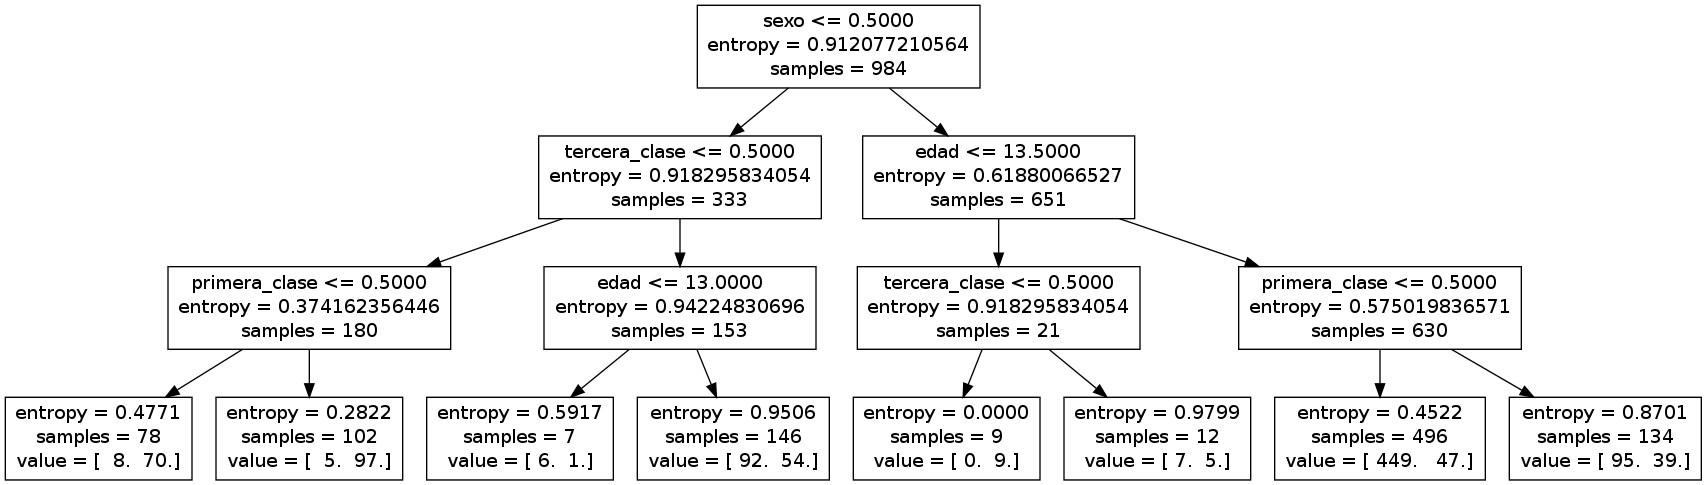

In [13]:
import StringIO
dot_data = StringIO.StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('titanic.png') 
from IPython.core.display import Image 
Image(filename='titanic.png')

Veamos cómo funciona nuestro modelo. Supongamos que había un hombre de 20 años en tercera clase (a.k.a. Leonardo di Caprio)... ¿se hubiera salvado?

In [20]:
print clf.predict([[20.0,1.0,0.0,0.0,1.0]])


[ 0.]


Nop. Podemos verificarlo siguiendo el árbol... 

Pero, ¿cómo sabemos qué tan bien anda en general nuestro clasificador? Empecemos por evaluarlo sobre los propios datos de entrenamiento, y viendo en cuántos casos acierta (esta medida se llama accuracy)... y algunas medidas más.

In [15]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        
measure_performance(X_train,y_train,clf, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.838 

Classification report
             precision    recall  f1-score   support

        0.0       0.82      0.98      0.89       662
        1.0       0.93      0.55      0.69       322

avg / total       0.85      0.84      0.82       984


Confusion matrix
[[649  13]
 [146 176]] 



El problema es que esto es riesgoso. Estamos evaluando sobre los mismos datos que utilziamos para crear el modelo! Esto siempre es una mala idea... para eso guardamos nuestro dataset de evaluación... evaluemos cómo se comporta nuestro modelo sobre este dataset: 

In [16]:
measure_performance(X_test,y_test, clf, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85       202
        1.0       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329


Confusion matrix
[[193   9]
 [ 59  68]] 

